#Sample training script with naive competitive self-play.

# Switch directory in Google drive so as to import CDA env.


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd

#!pip install -r requirements.txt
!pip install tensorflow==2.2.0
!pip install ray[rllib]==0.8.5

!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: grpcio, wrapt, astunparse, termcolor, opt-einsum, protobuf, six, scipy, keras-preprocessing, numpy, h5py, google-pasta, tensorflow-estimator, gast, wheel, tensorboard, absl-py
Required-by: fancyimpute
Name: ray
Version: 0.8.5
Summary: A system for parallel and distributed Python that unifies the ML ecosystem.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /

#Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import create_train_policy_list
from gym_continuousDoubleAuction.train.callbk.callbk_handler import store_eps_hist_data
#from gym_continuousDoubleAuction.train.logger.log_handler import
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_storage, plot_LOB_subplot, plot_sum_ord_imb, plot_mid_prices
from gym_continuousDoubleAuction.train.helper.helper import ord_imb, sum_ord_imb, mid_price

tf = try_import_tf()

In [0]:
@ray.remote(num_cpus=0.25, num_gpus=0.25)
class storage():
    """
    A remote object running as a ray detached actor on a separate process.
    """
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.prefix = "agt_"
        self.storage = self.create_storage(self.num_agents)
        self.eps_counter = 0

    def create_storage(self, num_agents):   
        """
        Global storage.
        """
        storage = {}
        for i in range(self.num_agents):
            storage[self.prefix + str(i)] = {"step": {"obs": [], 
                                                      "act": [],
                                                      "reward": [],
                                                      "NAV": [],
                                                      "num_trades": []},
                                             "eps":  {"policy_reward": [], 
                                                      "reward": [],
                                                      "NAV": [],
                                                      "num_trades": []}}
        return storage     

    def store(self, agt_id, step_or_eps, key, data):
        """
        agt_id: int
        step_or_eps: string
        key: string
        data: steps (in a list) or episodic data (a numeric value)
        """
        self.storage[self.prefix + str(agt_id)][step_or_eps][key].append(data)            

    def store_agt_step(self, agt_id, obs, act, reward, NAV, num_trades):
        self.store(agt_id, "step", "obs", obs)     # a dictionary
        self.store(agt_id, "step", "act", act)
        self.store(agt_id, "step", "reward", reward)
        self.store(agt_id, "step", "NAV", NAV)
        self.store(agt_id, "step", "num_trades", num_trades)

    def store_agt_eps(self, agt_id, reward, NAV, num_trades):
        self.store(agt_id, "eps", "reward", reward)
        self.store(agt_id, "eps", "NAV", NAV)
        self.store(agt_id, "eps", "num_trades", num_trades)

    def store_agt_train(self, agt_id, policy_reward):
        self.store(agt_id, "eps", "policy_reward", policy_reward)        

    def get_storage(self):
        return self.storage            

    def inc_eps_counter(self):
        self.eps_counter += 1

    def get_eps_counter(self):
        return self.eps_counter

    def get_obs_from_agt(self, agt_id, depth): 
        """
        Get bid_size, bid_price, ask_size, ask_price for all steps.
        """
        agt_key = "agt_" + str(agt_id)
        obs = self.storage[agt_key]["step"]["obs"]
        bid_size = np.empty((0, depth), float)
        bid_price = np.empty((0, depth), float)
        ask_size = np.empty((0, depth), float)
        ask_price = np.empty((0, depth), float)
        for eps_obs in obs:
            for step_obs in eps_obs:      # 4 rows in 1 step_obs
                bid_size_row = step_obs[0]
                bid_price_row = step_obs[1]
                ask_size_row = step_obs[2]
                ask_price_row = step_obs[3]
                bid_size = np.vstack((bid_size, bid_size_row))
                bid_price = np.vstack((bid_price, bid_price_row))
                ask_size = np.vstack((ask_size, ask_size_row))
                ask_price = np.vstack((ask_price, ask_price_row))  

        return np.transpose(bid_size), np.transpose(bid_price), np.transpose(ask_size), np.transpose(ask_price)     # shape(depth_lvl, steps)  
            

#Global


In [4]:
# CDA_env args
num_agents = 4
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 256 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False 

"""
# step storages
obs_step_store = create_storage(num_agents, "agt_", "_obs_step_list")
reward_step_store = create_storage(num_agents, "agt_", "_reward_step_list")
NAV_step_store = create_storage(num_agents, "agt_", "_NAV_step_list")
num_trades_step_store = create_storage(num_agents, "agt_", "_num_trades_step_list")

# episodic storages
policy_reward_store = create_storage(num_agents, "agt_", "_policy_reward_list")
reward_store = create_storage(num_agents, "agt_", "_reward_list")
NAV_store = create_storage(num_agents, "agt_", "_NAV_list")
num_trades_store = create_storage(num_agents, "agt_", "_num_trades_list")

# storage for json input
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")
"""

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
#num_cpus = 0.25                                
num_gpus = 0.25                        
num_cpus_per_worker = 0.25                                
num_gpus_per_worker = 0.25  
num_workers = 2
num_envs_per_worker = 4
rollout_fragment_length = 32
train_batch_size = max_step
sgd_minibatch_size = 64
num_iters = 1

log_base_dir = "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/"
log_dir = log_base_dir + "ray_results/"

# Chkpt & restore
local_dir = log_base_dir + "chkpt/"
chkpt_freq = 10
chkpt = 150
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False

"""
# log & load 
write_last_eps_steps_dir = log_base_dir + "last_eps_steps/"
write_eps_dir = log_base_dir + "eps/"
create_dir(write_last_eps_steps_dir)    
create_dir(write_eps_dir)    
threshold = log_threshold(num_workers, num_envs_per_worker, num_iters, num_agents)
print("threshold", threshold)
"""

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
g_store = storage.options(name="g_store", detached=True).remote(num_agents)

2020-06-15 11:28:22,350	INFO resource_spec.py:212 -- Starting Ray with 7.13 GiB memory available for workers and up to 3.58 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1']


2020-06-15 11:28:22,789	INFO services.py:1170 -- View the Ray dashboard at 127.0.0.1:8265


#Policies

In [5]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            return "policy_{}".format(i)                

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


# Call back.

In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.

    user_data dicts at 100000 items max, will auto replace old with new item at 1st index.
    hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
    """
    episode = info["episode"] 
    #print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))

    prefix = "agt_"
    for i in range(num_agents):
        episode.user_data[prefix + str(i) + "_obs"] = []
        episode.user_data[prefix + str(i) + "_act"] = []
        episode.user_data[prefix + str(i) + "_reward"] = []
        episode.user_data[prefix + str(i) + "_NAV"] = []
        episode.user_data[prefix + str(i) + "_num_trades"] = []

        episode.hist_data[prefix + str(i) + "_reward"] = []
        episode.hist_data[prefix + str(i) + "_NAV"] = []
        episode.hist_data[prefix + str(i) + "_num_trades"] = [] 

In [0]:
def on_episode_step(info):
    episode = info["episode"]

    prefix = "agt_"
    for i in range(num_agents):
        obs = episode.last_raw_obs_for(i)
        #obs = episode.last_observation_for(i)
        act = episode.last_action_for(i)
        reward = episode.last_info_for(i).get("reward")
        NAV = episode.last_info_for(i).get("NAV")
        NAV = None if NAV is None else float(NAV)
        num_trades = episode.last_info_for(i).get("num_trades")
        
        if reward is None:      # goto next agent.
            continue

        episode.user_data[prefix + str(i) + "_obs"].append(obs)    
        episode.user_data[prefix + str(i) + "_act"].append(act)    
        episode.user_data[prefix + str(i) + "_reward"].append(reward)    
        episode.user_data[prefix + str(i) + "_NAV"].append(NAV)    
        episode.user_data[prefix + str(i) + "_num_trades"].append(num_trades)                                    

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """
    episode = info["episode"]

    g_store = ray.util.get_actor("g_store")
    prefix = "agt_"
    for agt_id in range(num_agents):
        obs_key = prefix + str(agt_id) + "_obs"
        act_key = prefix + str(agt_id) + "_act"
        reward_key = prefix + str(agt_id) + "_reward"
        NAV_key = prefix + str(agt_id) + "_NAV"
        num_trades_key = prefix + str(agt_id) + "_num_trades"      

        # store into episode.hist_data
        store_eps_hist_data(episode, reward_key)
        store_eps_hist_data(episode, NAV_key)
        store_eps_hist_data(episode, num_trades_key)

        # store step data
        obs = episode.user_data[obs_key]
        act = episode.user_data[act_key]
        reward = episode.user_data[reward_key]
        NAV = episode.user_data[NAV_key]
        num_trades = episode.user_data[num_trades_key]
        ray.get(g_store.store_agt_step.remote(agt_id, obs, act, reward, NAV, num_trades))       
        
        # Store episode data.   
        eps_reward = np.sum(reward)
        eps_NAV = np.sum(NAV)
        eps_num_trades = np.sum(num_trades)
        ray.get(g_store.store_agt_eps.remote(agt_id, eps_reward, eps_NAV, eps_num_trades))

    ray.get(g_store.inc_eps_counter.remote())  

In [0]:
def on_sample_end(info):
    """
    arg: {"samples": .., "worker": ...}
    """

    """
    Notes:
        https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py
    """
    MultiAgentBatch_obj = info["samples"]
    MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
    MultiAgentBatch_count = MultiAgentBatch_obj.count

    #access_sample_batches(MultiAgentBatch_policy_batches)
    #print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
    #print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object

In [0]:
def on_postprocess_traj(info):
    """
    arg: {"agent_id": ..., "episode": ...,
          "pre_batch": (before processing),
          "post_batch": (after processing),
          "all_pre_batches": (other agent ids),
          }

    # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
    Dictionaries in a sample_obj, k:
        t
        eps_id
        agent_index
        obs
        actions
        rewards
        prev_actions
        prev_rewards
        dones
        infos
        new_obs
        action_prob
        action_logp
        vf_preds
        behaviour_logits
        unroll_id       
    """

    """
    policy_obj = info["pre_batch"][0]
    sample_obj = info["pre_batch"][1]    
    agt_id = info["agent_id"]
    eps_id = info["episode"].episode_id
    """

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """
    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
    max_reward_ind = get_max_reward_ind(info, train_policies_name)
    max_reward_policy_name = train_policies_name[max_reward_ind]
    cp_weight(info["trainer"], train_policies_name, max_reward_policy_name)    

    g_store = ray.util.get_actor("g_store")      
    prefix = "policy_policy_"
    suffix = "_reward"
    hist_stats = info["result"]["hist_stats"]
    eps_this_iter = info["result"]["episodes_this_iter"]
    for agt_id in range(num_agents):
        key = prefix + str(agt_id) + suffix
        for i in range(eps_this_iter):
            ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

    #print("on_train_result info['result'] {}".format(info["result"]))     

#RLlib config

In [0]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
    config["num_gpus"] = num_gpus     # trainer
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": on_episode_step, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": on_sample_end,
                           "on_postprocess_traj": on_postprocess_traj,
                           "on_train_result": on_train_result,}
    config["output"] = log_dir

    return config

#Train


In [13]:
def go_train(config):    
    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
    if is_restore == True:
        trainer.restore(restore_path) 

    g_store = ray.util.get_actor("g_store")          
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print(pretty_print(result)) # includes result["custom_metrics"]
        print("training loop = {} of {}".format(i + 1, num_iters))            
        print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))

        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)


# run everything
go_train(get_config())            

2020-06-15 11:28:23,556	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-06-15 11:28:23,680	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!
2020-06-15 11:28:23,687	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-06-15 11:28:23,719	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!


(pid=2843) 2020-06-15 11:28:36,344	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!
(pid=2934) 2020-06-15 11:28:37,652	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!


2020-06-15 11:28:48,137	INFO trainable.py:180 -- _setup took 24.468 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-06-15 11:28:48,139	INFO trainable.py:217 -- Getting current IP.
2020-06-15 11:28:48,145	WARNING util.py:37 -- Install gputil for GPU system monitoring.


callback_ok: true
custom_metrics:
  agt_0_NAV_max: 1001167.56640625
  agt_0_NAV_mean: 1000327.0390625
  agt_0_NAV_min: 999486.51171875
  agt_0_num_trades_max: 37.41015625
  agt_0_num_trades_mean: 36.82421875
  agt_0_num_trades_min: 36.23828125
  agt_0_reward_max: -8854.970047563816
  agt_0_reward_mean: -42906.97945058337
  agt_0_reward_min: -76958.98885360293
  agt_1_NAV_max: 1006354.0625
  agt_1_NAV_mean: 1002112.8515625
  agt_1_NAV_min: 997871.640625
  agt_1_num_trades_max: 60.5625
  agt_1_num_trades_mean: 49.384765625
  agt_1_num_trades_min: 38.20703125
  agt_1_reward_max: -25914.21794538538
  agt_1_reward_mean: -57268.32036726941
  agt_1_reward_min: -88622.42278915344
  agt_2_NAV_max: 1010233.35546875
  agt_2_NAV_mean: 1002516.95703125
  agt_2_NAV_min: 994800.55859375
  agt_2_num_trades_max: 33.86328125
  agt_2_num_trades_mean: 31.220703125
  agt_2_num_trades_min: 28.578125
  agt_2_reward_max: -6179.918905247474
  agt_2_reward_mean: -10838.480126139755
  agt_2_reward_min: -15497.04

# Plot steps from all episodes.

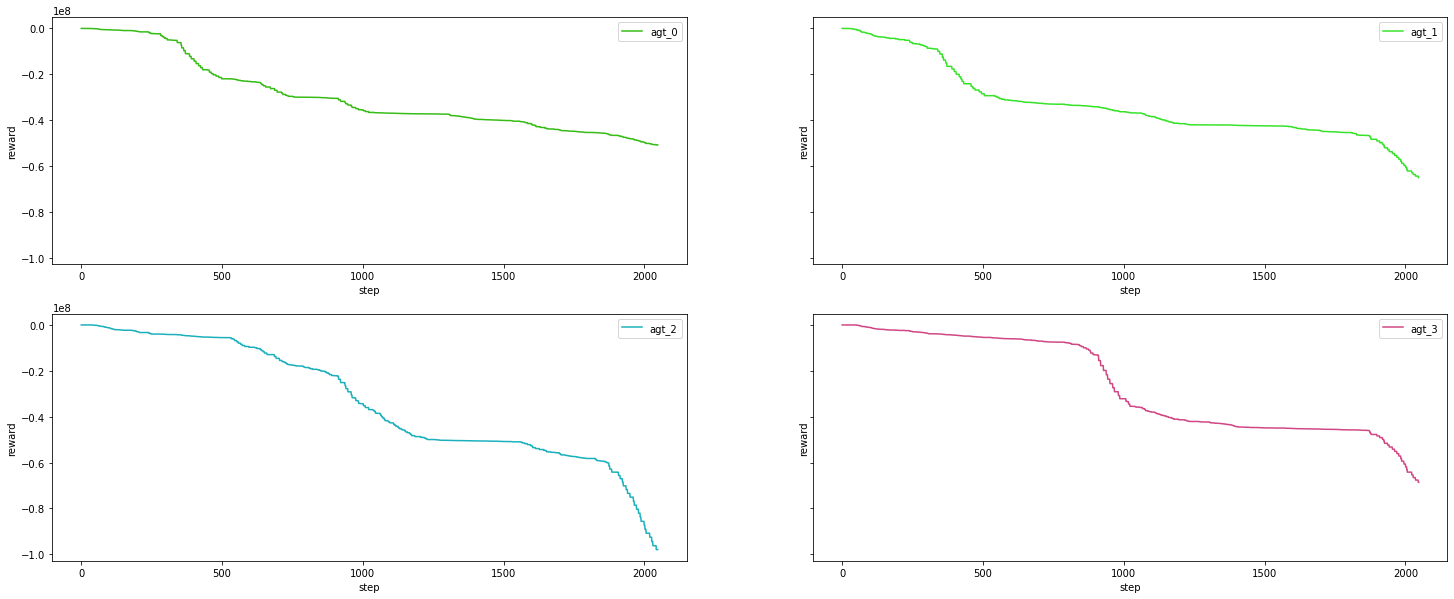

In [14]:
plot_storage(num_agents, init_cash)

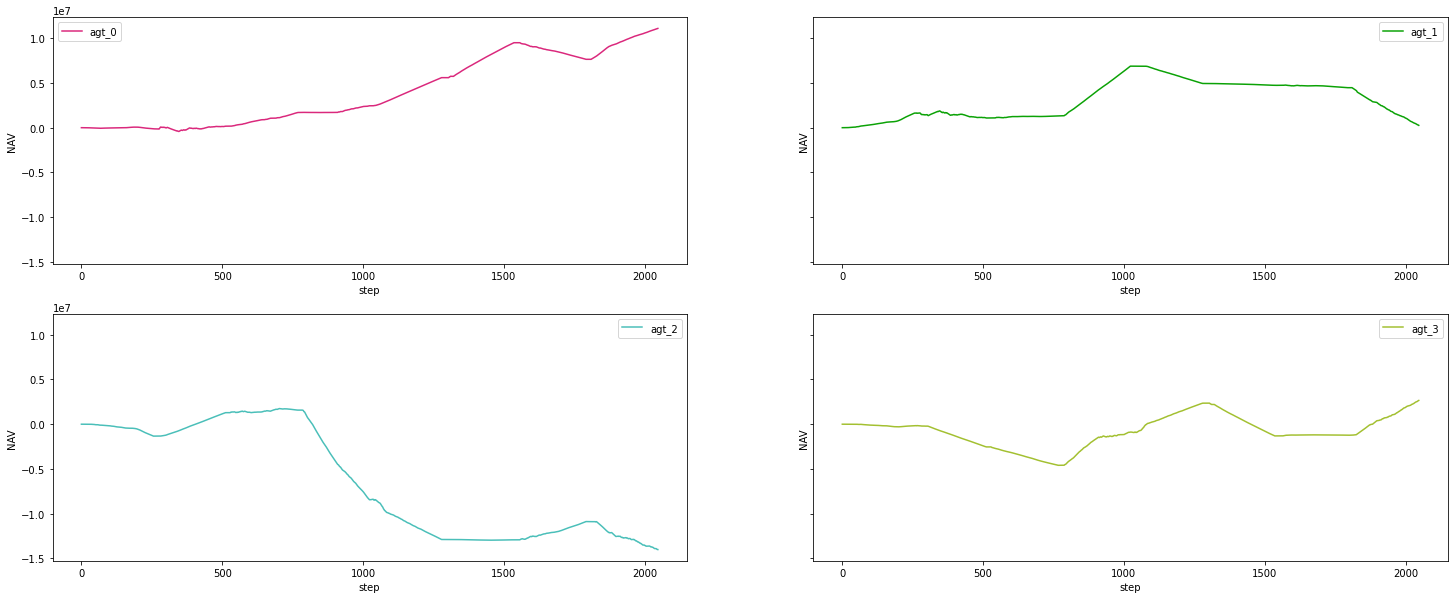

In [15]:
plot_storage(num_agents, init_cash, "step", "NAV")

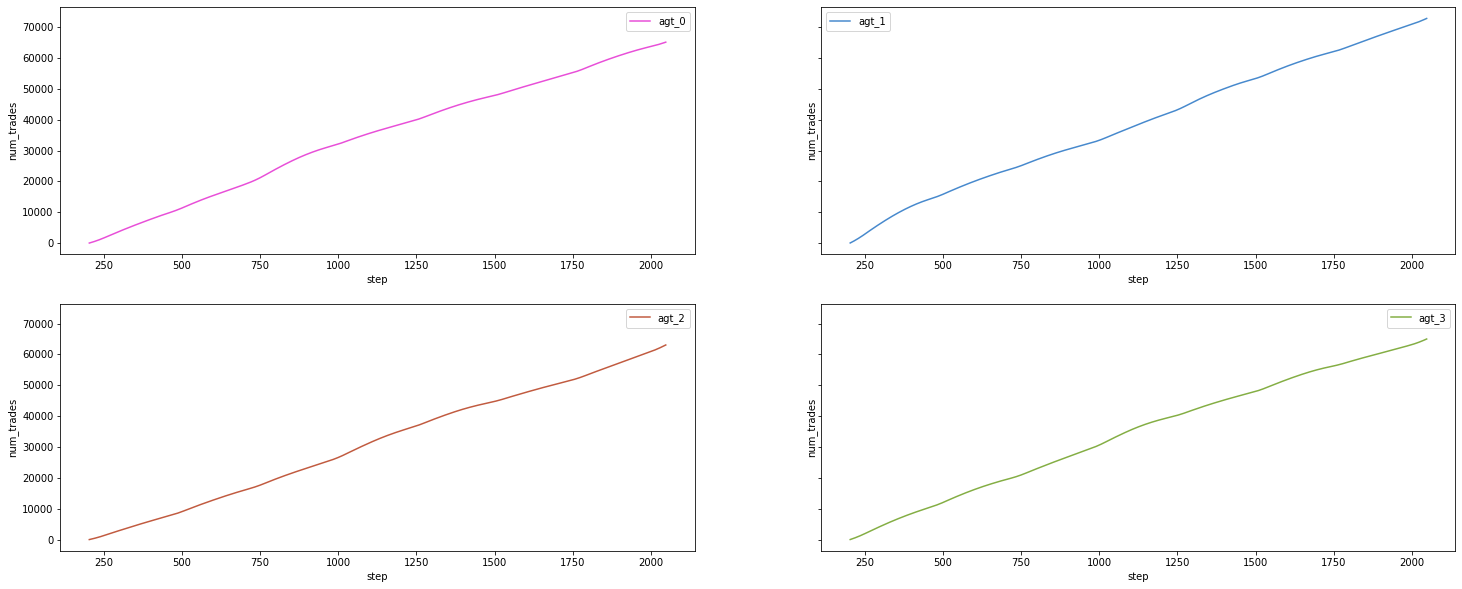

In [16]:
plot_storage(num_agents, init_cash, "step", "num_trades")

#LOB

In [0]:
g_store = ray.util.get_actor("g_store")          
#store = ray.get(g_rere.get_storage.remote())

depth = 10
bid_size, bid_price, ask_size, ask_price = ray.get(g_store.get_obs_from_agt.remote(0, depth))

#LOB order imbalance

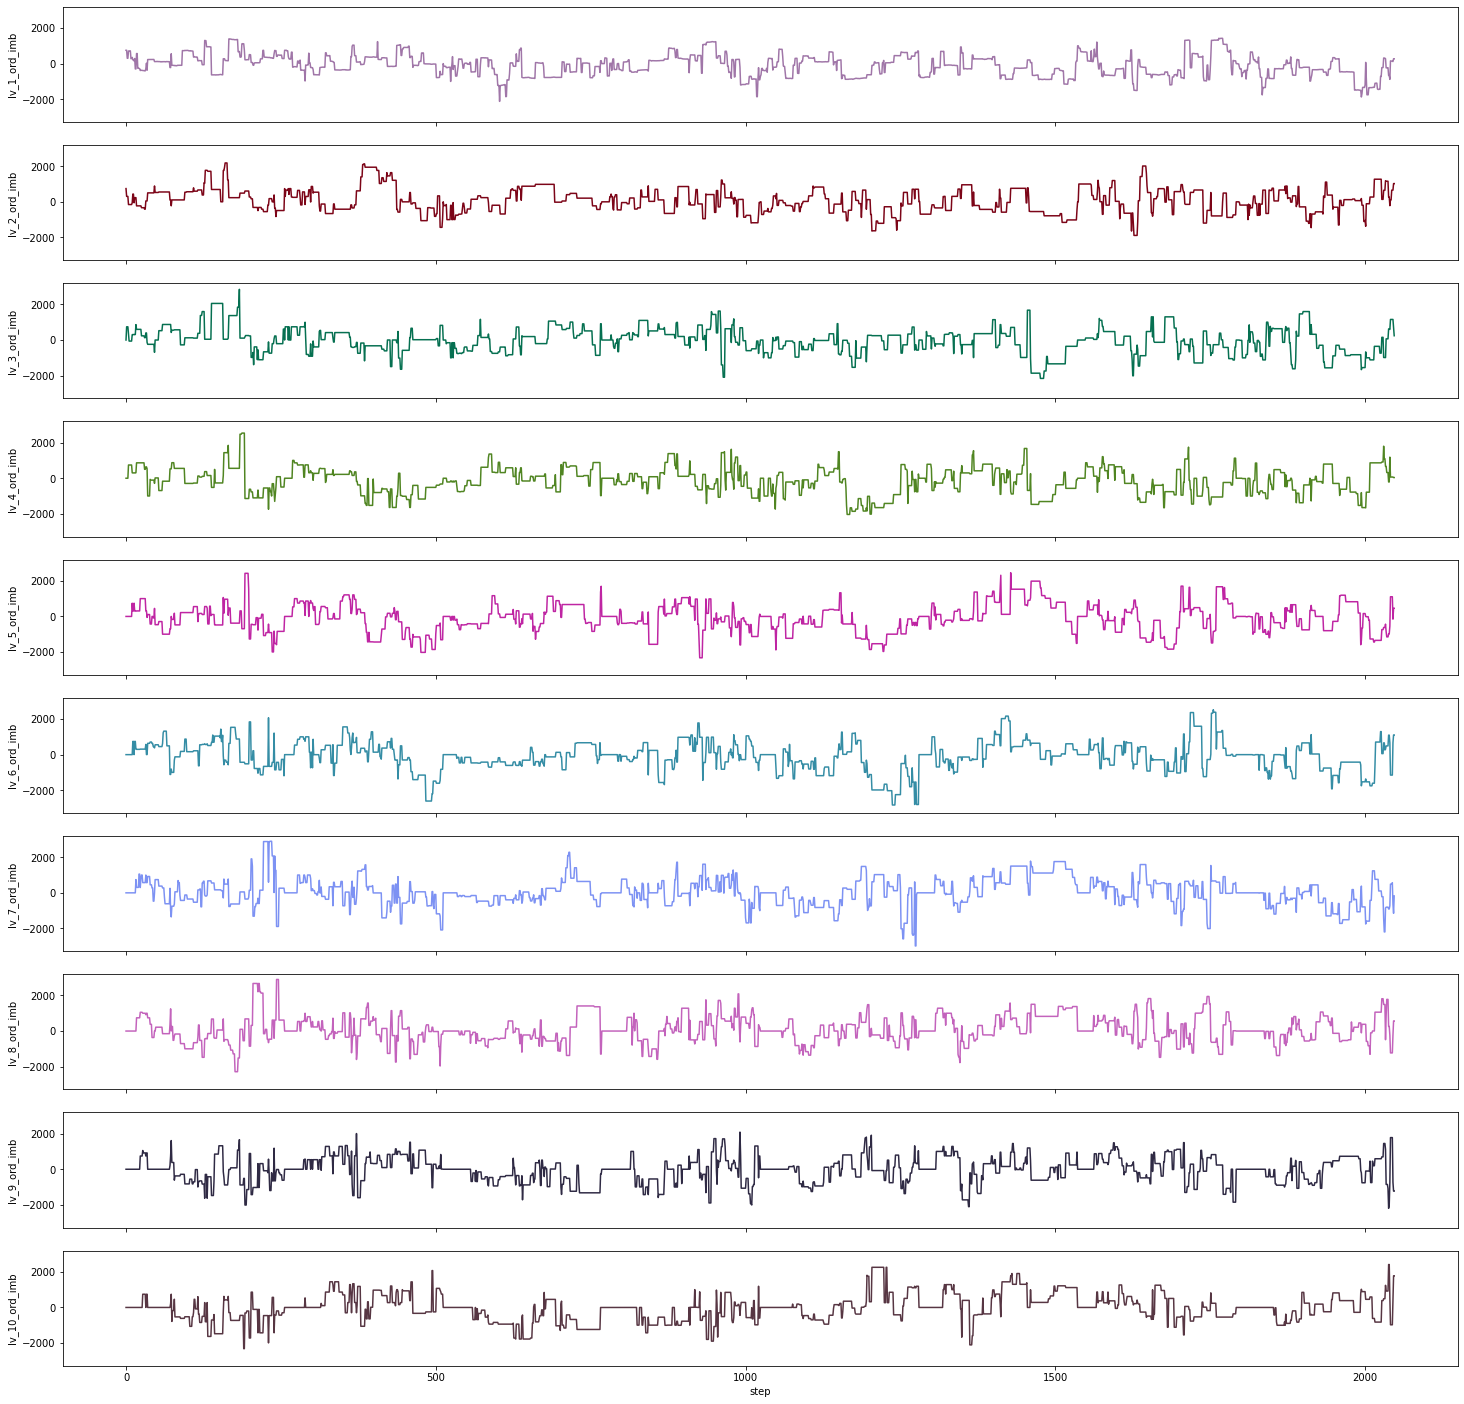

In [18]:
ord_imb_store = ord_imb(bid_size, ask_size)
plot_LOB_subplot(ord_imb_store, depth, '_ord_imb') 

#LOB sum of order imbalance

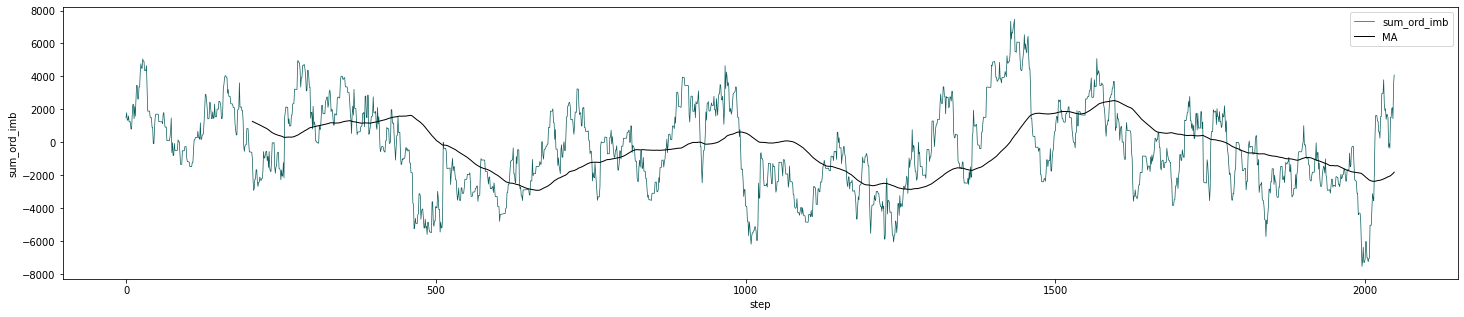

In [19]:
ord_imb_store = np.asarray(ord_imb_store)
sum_ord_imb_store = sum_ord_imb(ord_imb_store)
plot_sum_ord_imb(sum_ord_imb_store, "sum_ord_imb")

#LOB mid price (subplot)

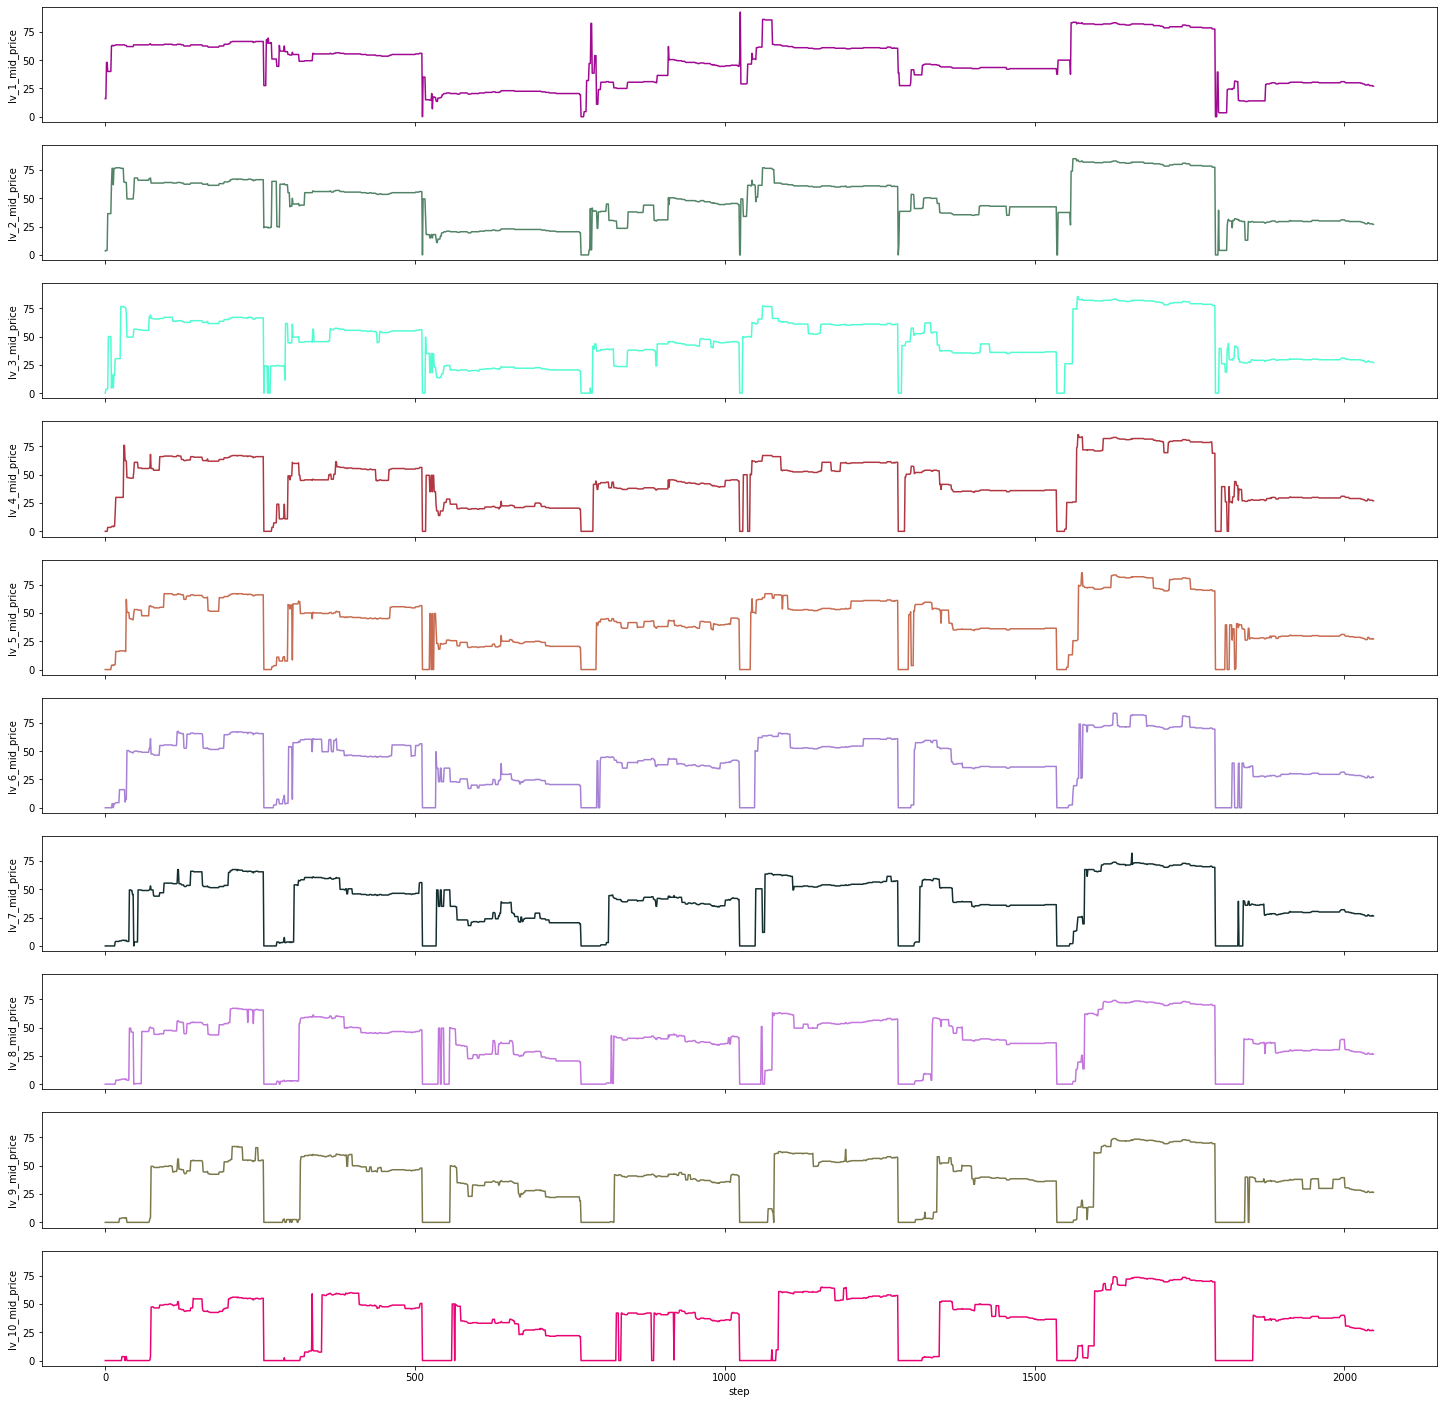

In [20]:
mid_price_store = mid_price(bid_price, ask_price)
plot_LOB_subplot(mid_price_store, depth, '_mid_price')    

#LOB mid prices 

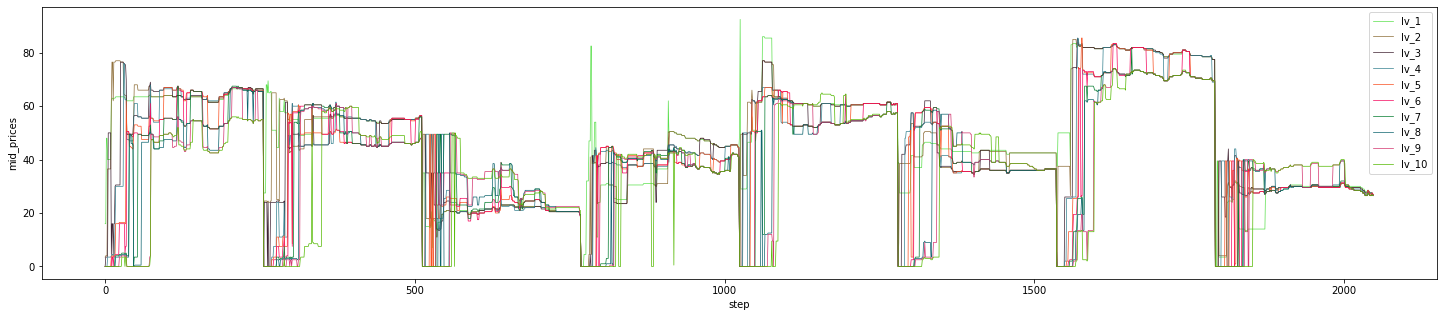

In [21]:
plot_mid_prices(mid_price_store,)

# LOB bid size

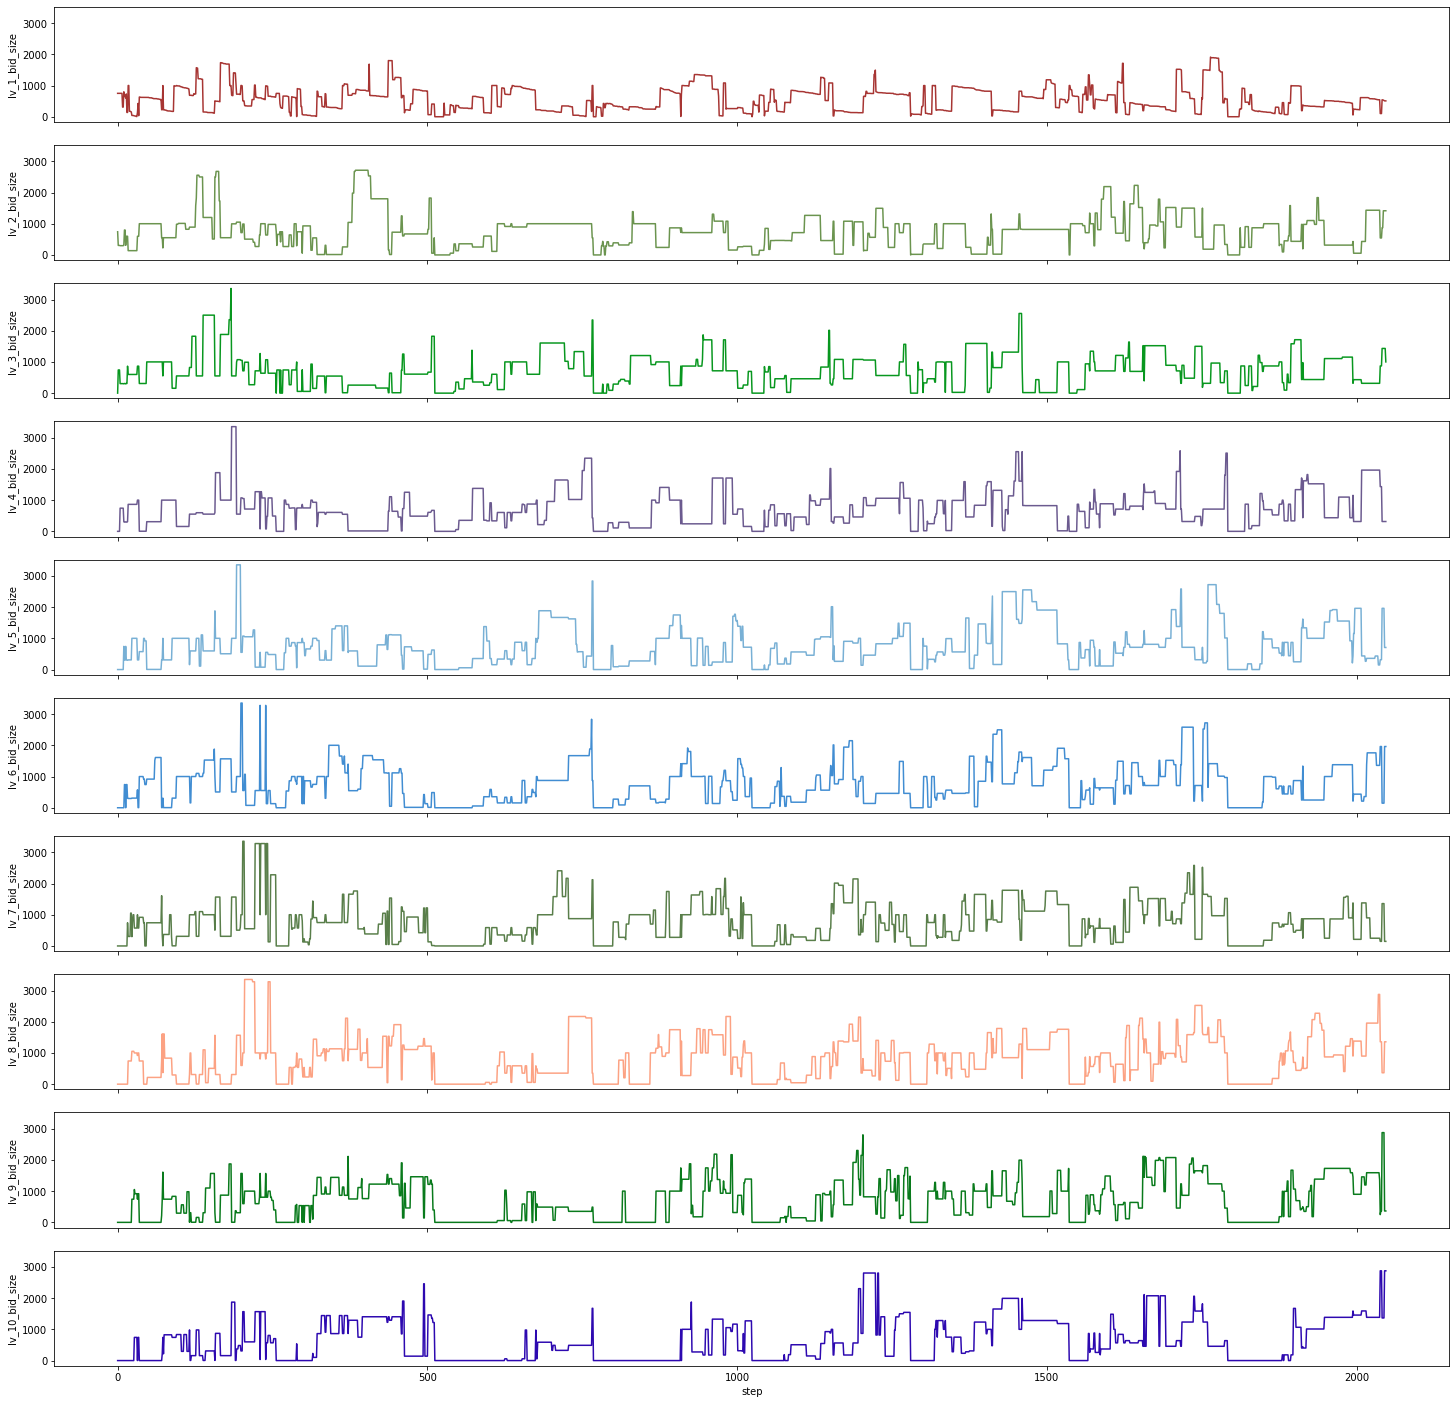

In [22]:
plot_LOB_subplot(bid_size, depth, '_bid_size')    

#LOB ask size

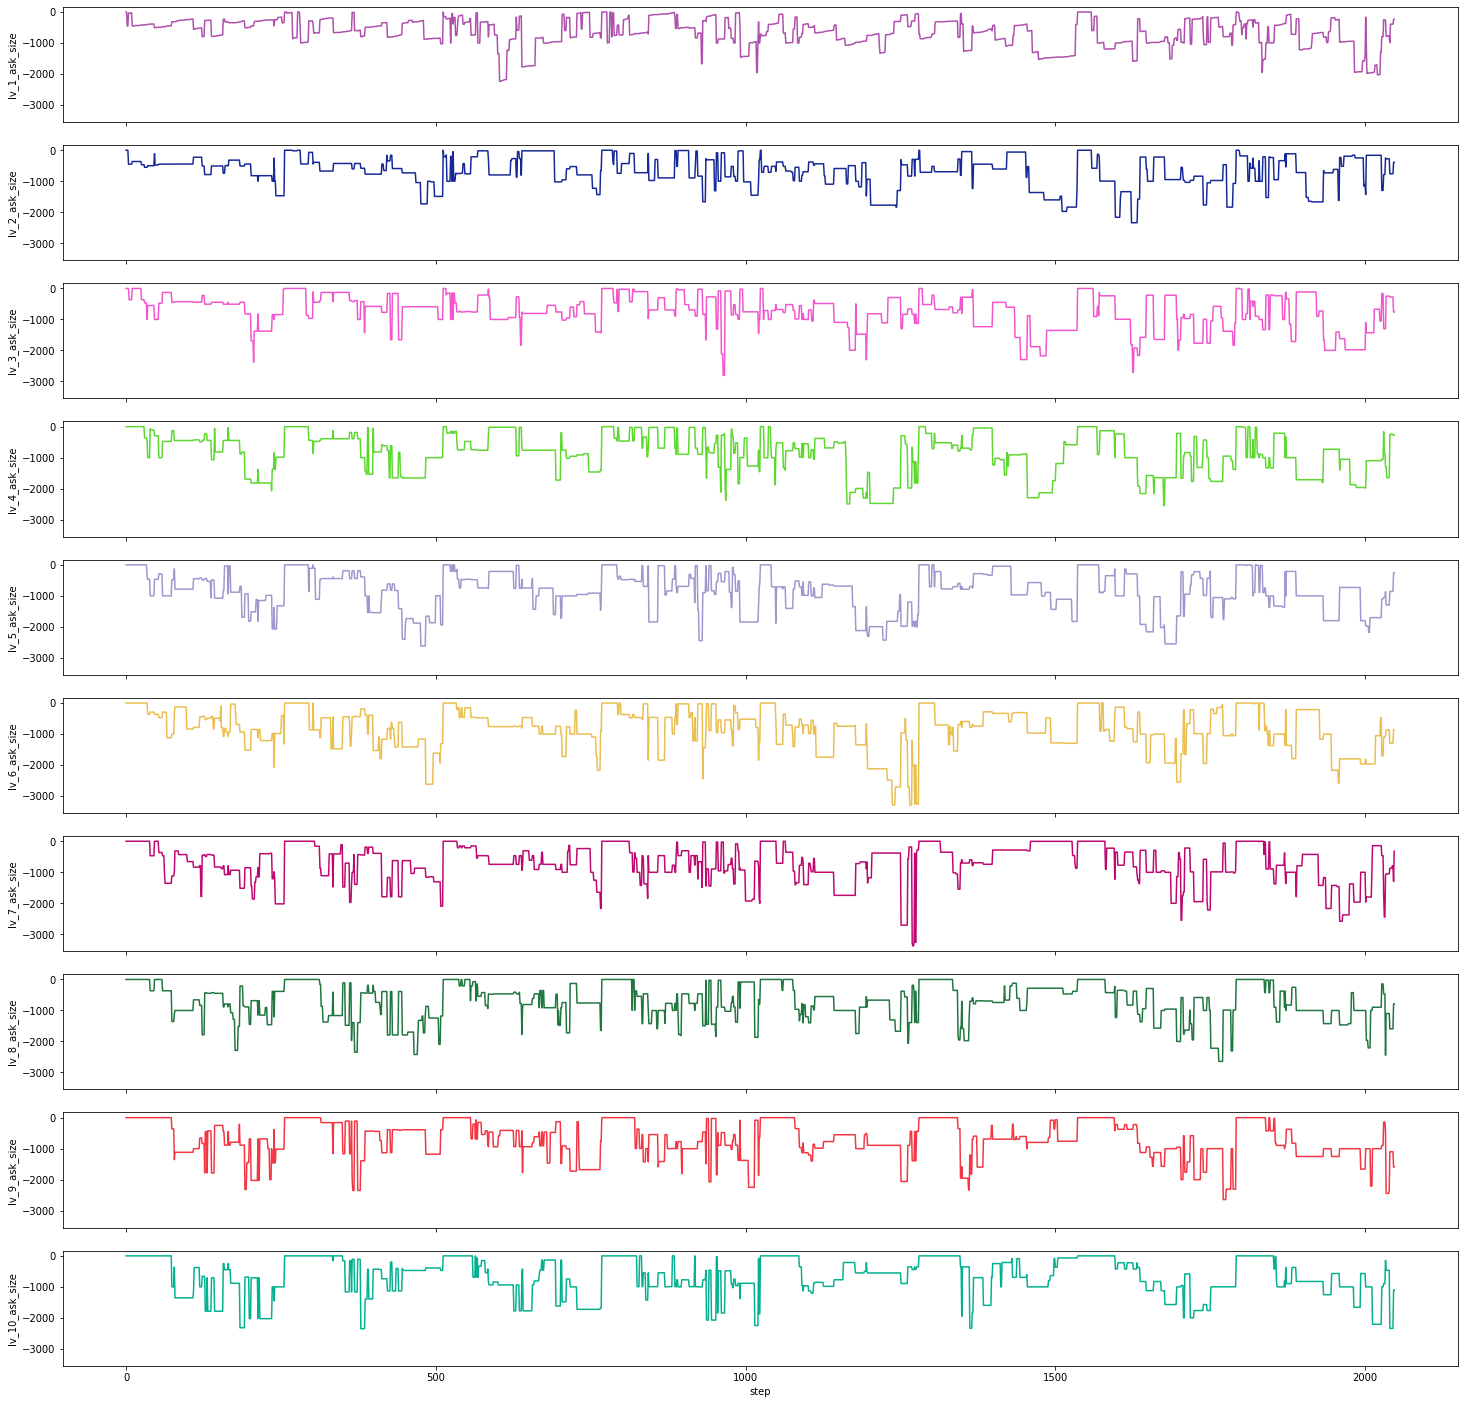

In [23]:
plot_LOB_subplot(ask_size, depth, '_ask_size')    

#LOB bid price

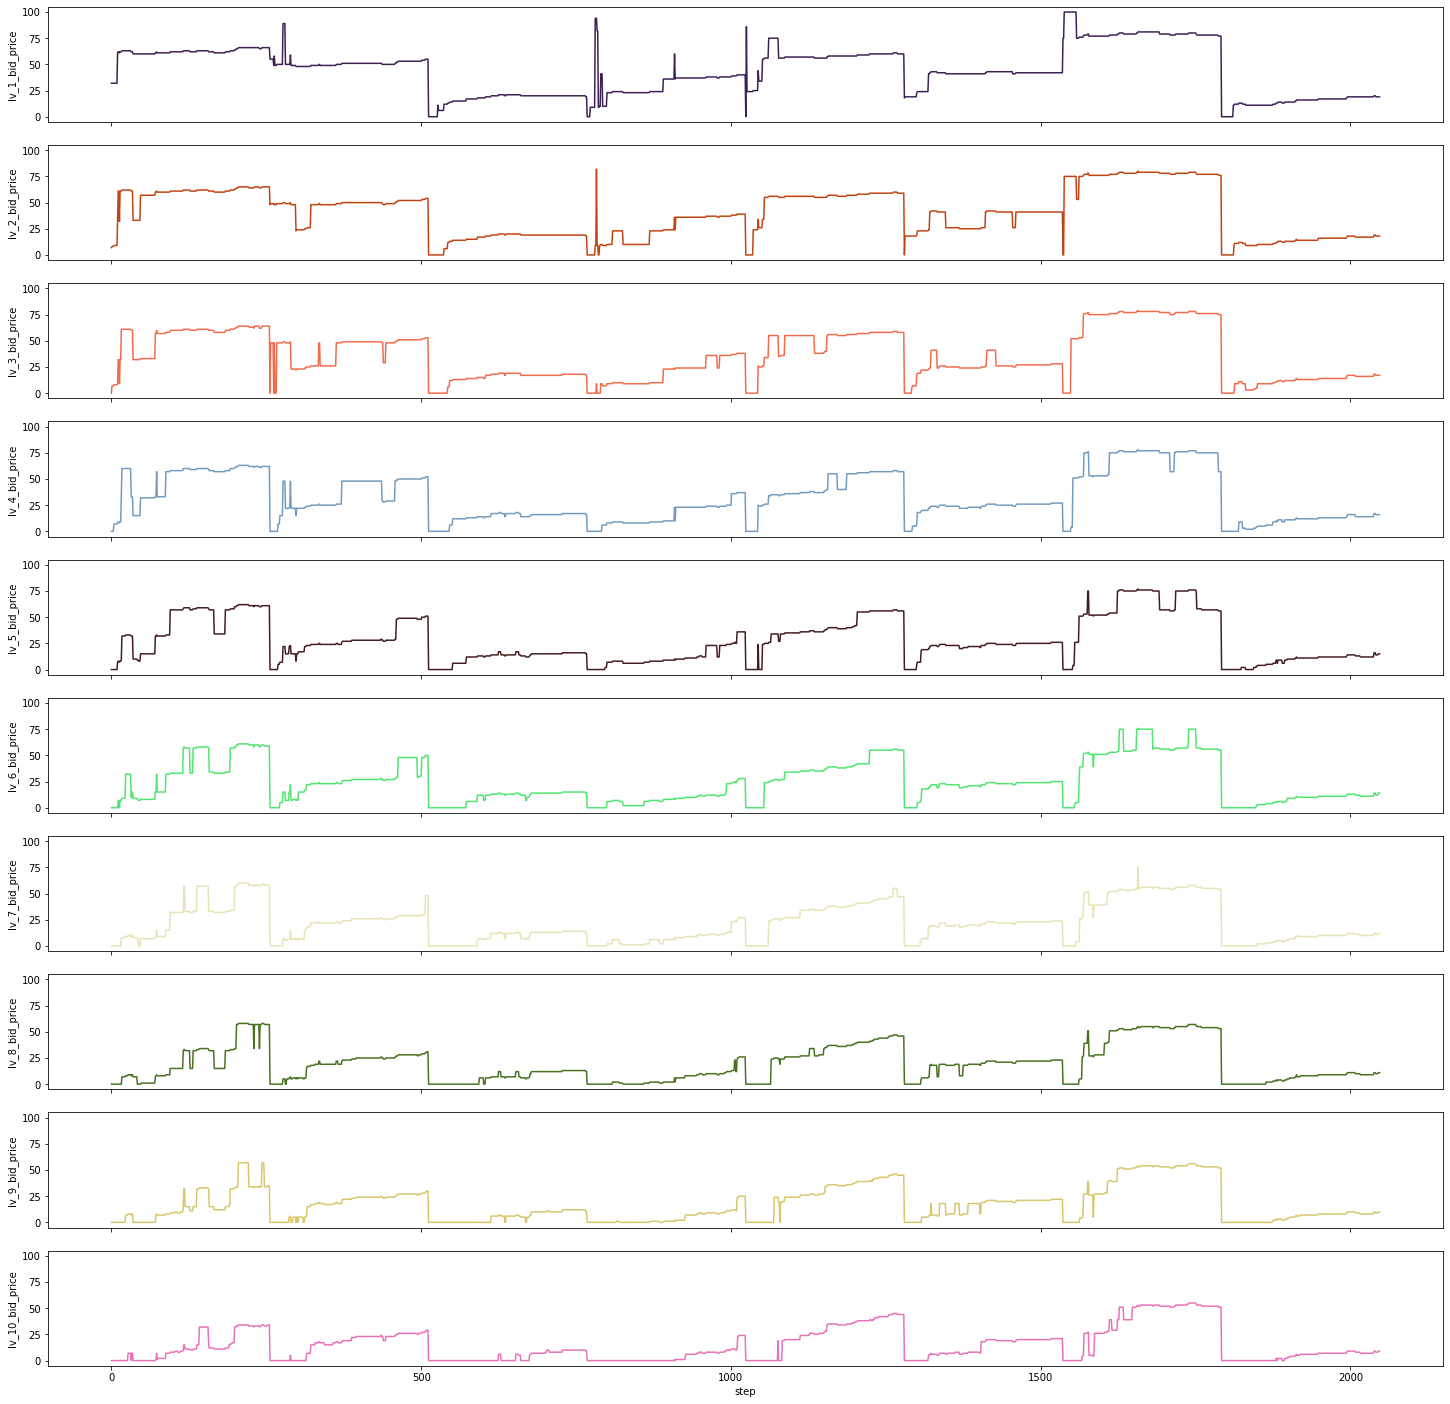

In [24]:
plot_LOB_subplot(bid_price, depth, '_bid_price')    

#LOB ask price

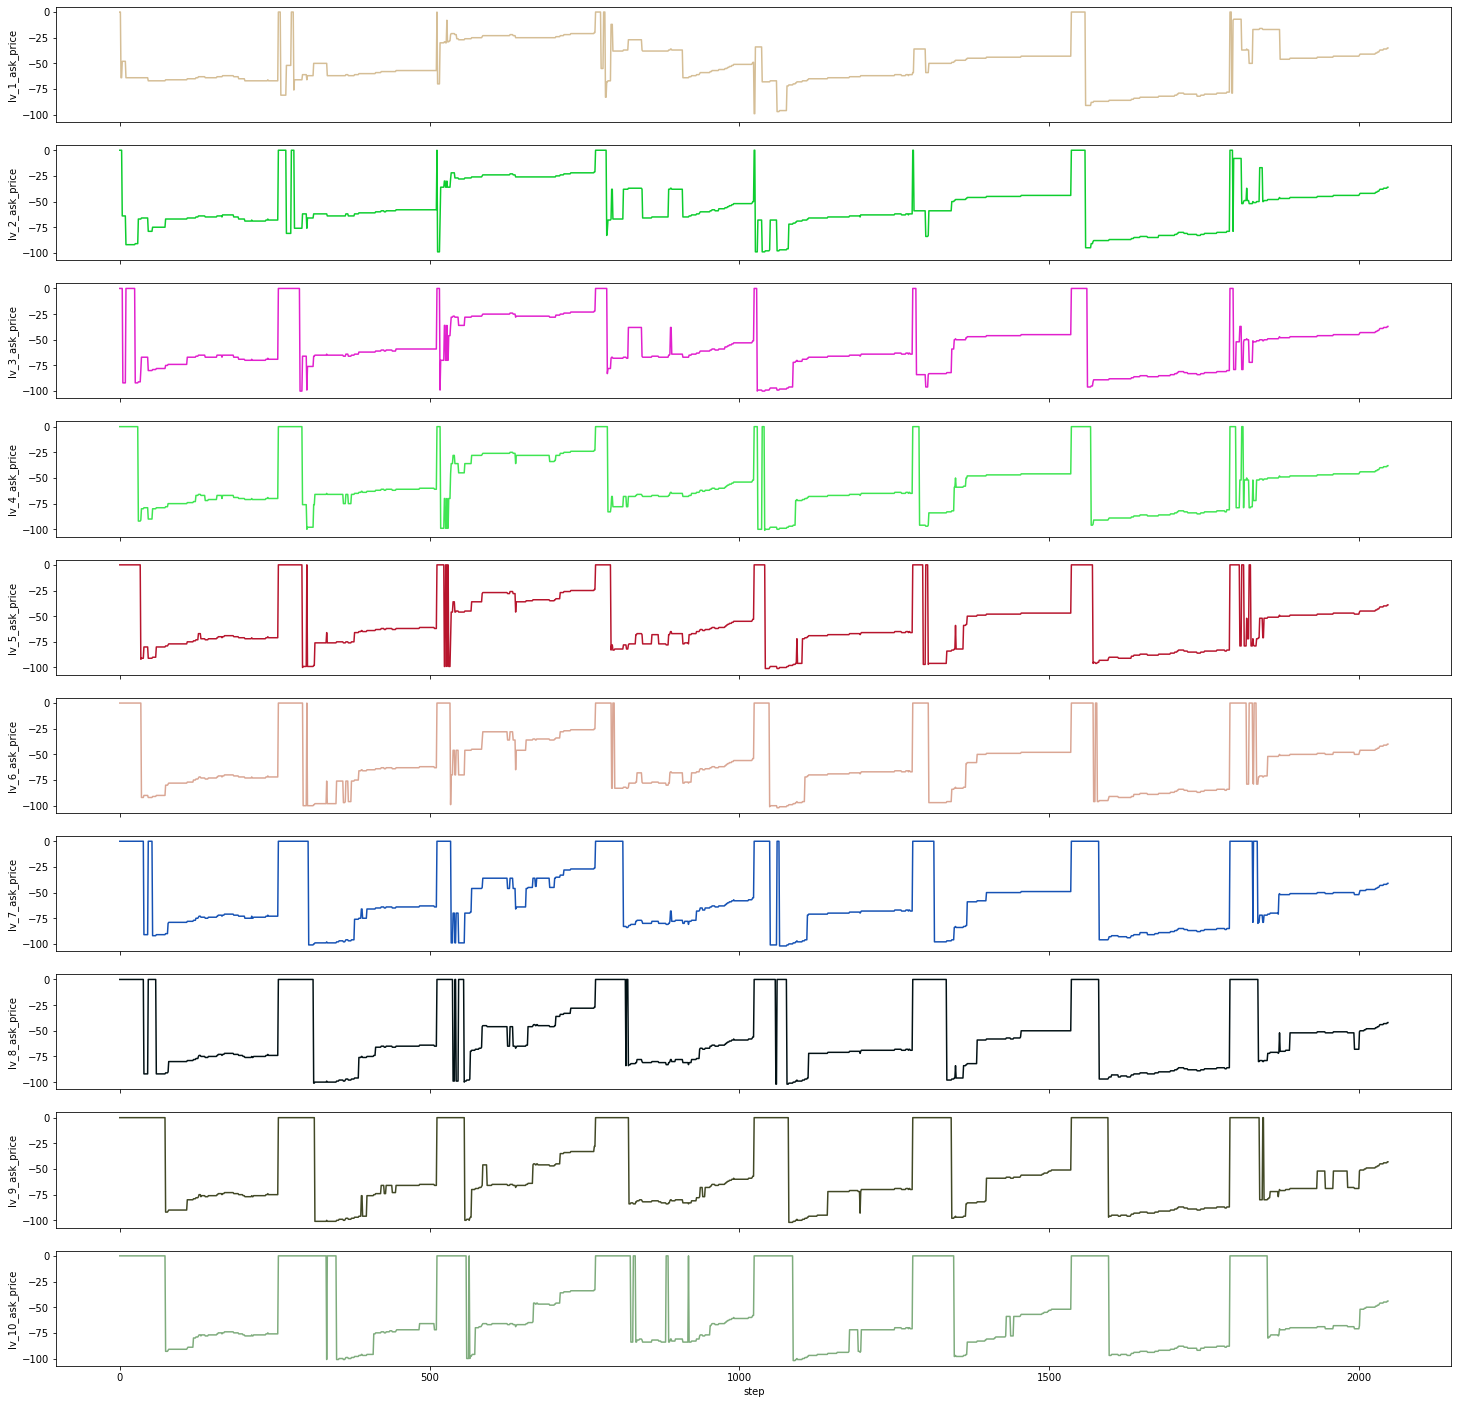

In [25]:
plot_LOB_subplot(ask_price, depth, '_ask_price')    